<a href="https://colab.research.google.com/drive/1FNUTbp9735lRMWQYempPEhgbhfmEBbCP#scrollTo=eIEtviGCnZan" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install scikit-plot

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from zipfile import ZipFile 

DATA = "feraligned+ck"
file_name = f"drive/My Drive/Advanced Networks/datasets/{DATA}.zip"

with ZipFile(file_name, 'r') as zip_:
    print('Extracting all the files...') 
    zip_.extractall()
    print('Done!')

Extracting all the files...
Done!


In [0]:
import os
import cv2
import math
import joblib
import numpy as np

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, ZeroPadding2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, concatenate
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
tf.__version__

'2.2.0'

In [0]:
BASE_PATH = "drive/My Drive/FER/Colab/GauravSharma/AdvancedNetworks/"
DATA_PATH = DATA + "/"
TOP_EMOTIONS = ["Happy", "Neutral", "Sadness"]

TRAIN_SIZE = 0.86
INPUT_SHAPE = (48,48,1)
NUM_CLASSES = len(TOP_EMOTIONS)

In [0]:
total_images = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        count = 0
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of images")
        total_images += count

print(f"\ntotal images are {total_images}")

Happy has 2203 number of images
Sadness has 1153 number of images
Neutral has 1230 number of images

total images are 4586


In [0]:
img_arr = []
img_label = []
label_to_text = {}
label = 0

for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img_arr.append(np.expand_dims(cv2.imread(DATA_PATH + dir_ + "/" + f, 0), axis=2))
            img_label.append(label)
        print(f"loaded {dir_} images to numpy arrays...")
        label_to_text[label] = dir_
        label += 1

img_arr = np.array(img_arr)
img_label = np.array(img_label)
img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1,1))

img_arr.shape, img_label.shape, label_to_text

loaded Happy images to numpy arrays...
loaded Sadness images to numpy arrays...
loaded Neutral images to numpy arrays...


((4586, 48, 48, 1), (4586, 3), {0: 'Happy', 1: 'Sadness', 2: 'Neutral'})

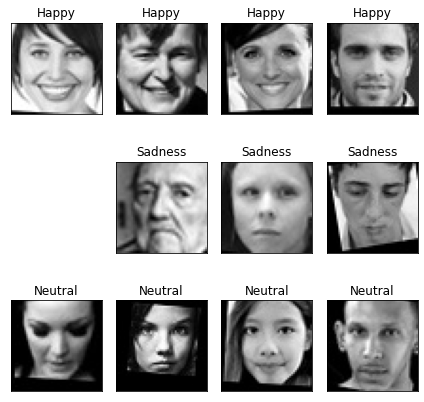

In [0]:
num_emotions = len(TOP_EMOTIONS)
fig = pyplot.figure(1, (num_emotions*2, num_emotions*2))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(num_emotions,4,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [0]:
img_arr = img_arr / 255.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=TRAIN_SIZE, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3943, 48, 48, 1), (643, 48, 48, 1), (3943, 3), (643, 3))

In [0]:
def inception_block(X,
                    filters_1x1: int,
                    filters_3x3_reduce: int,
                    filters_3x3: int,
                    filters_5x5_reduce: int,
                    filters_5x5: int,
                    filters_pool_proj: int,
                    block_name: str):
    
    conv_1x1 = Conv2D(
            filters=filters_1x1,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_1x1",
        )(X)
    
    conv_3x3_reduce = Conv2D(
            filters=filters_3x3_reduce, 
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_3x3_reduce",
        )(X)
    conv_3x3 = Conv2D(
            filters=filters_3x3, 
            kernel_size=(3,3),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_3x3",
        )(conv_3x3_reduce)

    conv_5x5_reduce = Conv2D(
            filters=filters_5x5_reduce, 
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_5x5_reduce",
        )(X)
    conv_5x5 = Conv2D(
            filters=filters_5x5, 
            kernel_size=(5,5),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_5x5",
        )(conv_5x5_reduce)

    pool_proj = MaxPool2D(
        pool_size=(3, 3),
        strides=(1, 1),
        padding='same',
        name=f"incepblock{block_name}_maxpool",
    )(X)
    conv_after_pool = Conv2D(
            filters=filters_pool_proj,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_afterpool",
        )(pool_proj)

    concated = concatenate([conv_1x1, conv_3x3, conv_5x5, conv_after_pool], axis=3, name=f"incepblock{block_name}_concat")
    return concated

In [0]:
def auxiliary_block(X, out_shape: int, block_id: int):
    X = AveragePooling2D(
        pool_size=(3,3),
        strides=(1,1),
        padding='valid',
        name=f"auxblock{block_id}_avgpool",
    )(X)

    X = Conv2D(
            filters=128,
            kernel_size=(1,1),
            strides=(1,1),
            padding='same',
            activation='relu',
            name=f"auxblock{block_id}_conv2d",
    )(X)

    X = Flatten(name=f"auxblock{block_id}_flatten",)(X)

    X = Dense(units=128, activation='relu', name=f"auxblock{block_id}_dense1",)(X)
    
    X = Dropout(0.25, name=f"auxblock{block_id}_dropout",)(X)
    
    X = Dense(units=out_shape, activation='softmax', name=f"auxblock{block_id}_outlayer",)(X)
    return X

In [0]:
def InceptionNet(in_shape, out_shape, show_summary=False):
    "shallow inception-net without auxiliary layers"

    model_in = Input(shape=in_shape, name="in_layer")

    X = Conv2D(
            filters=32,
            kernel_size=(3,3),
            padding='same',
            strides=(1,1),
            activation='relu', 
            kernel_initializer=he_normal(seed=42)
        )(model_in)
    X = Conv2D(
            filters=64,
            kernel_size=(1,1),
            padding='same',
            strides=(1,1),
            activation='relu', 
            kernel_initializer=he_normal(seed=42)
        )(X)

    X = MaxPool2D(
        (3, 3),
        padding='same',
        strides=(2, 2),
        )(X)

    X = inception_block(X,
            filters_1x1=64,
            filters_3x3_reduce=96,
            filters_3x3=128,
            filters_5x5_reduce=16,
            filters_5x5=32,
            filters_pool_proj=32,
            block_name='1a'
    )
    X = inception_block(X,
            filters_1x1=128,
            filters_3x3_reduce=128,
            filters_3x3=192,
            filters_5x5_reduce=32,
            filters_5x5=96,
            filters_pool_proj=64,
            block_name='1b'
    )
    
    X = MaxPool2D(
        (3, 3),
        padding='same',
        strides=(2, 2),
        )(X)

    X = inception_block(
        X,
        filters_1x1=192,
        filters_3x3_reduce=96,
        filters_3x3=208,
        filters_5x5_reduce=16,
        filters_5x5=48,
        filters_pool_proj=64,
        block_name='2a'
    )
    X = inception_block(
        X,
        filters_1x1=160,
        filters_3x3_reduce=112,
        filters_3x3=224,
        filters_5x5_reduce=24,
        filters_5x5=64,
        filters_pool_proj=64,
        block_name='2b'
    )

    X = MaxPool2D(
        (3, 3),
        padding='same',
        strides=(2, 2),
        )(X)

    X = inception_block(
        X,
        filters_1x1=256,
        filters_3x3_reduce=160,
        filters_3x3=320,
        filters_5x5_reduce=32,
        filters_5x5=128,
        filters_pool_proj=128,
        block_name='3a'
    )
    X = inception_block(
        X,
        filters_1x1=384,
        filters_3x3_reduce=192,
        filters_3x3=384,
        filters_5x5_reduce=48,
        filters_5x5=128,
        filters_pool_proj=128,
        block_name='3b'
    )

    X = GlobalAveragePooling2D()(X)

    X = Dense(128, activation='relu')(X)
    X = Dropout(0.25)(X)

    model_out = Dense(out_shape, activation="softmax", name="out_layer")(X)

    model = Model(model_in, model_out, name="InceptionNet")

    if show_summary:
        model.summary()

    return model

In [0]:
model = InceptionNet(INPUT_SHAPE, NUM_CLASSES, show_summary=True)

Model: "InceptionNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_layer (InputLayer)           [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 32)   320         in_layer[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 64)   2112        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 24, 64)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

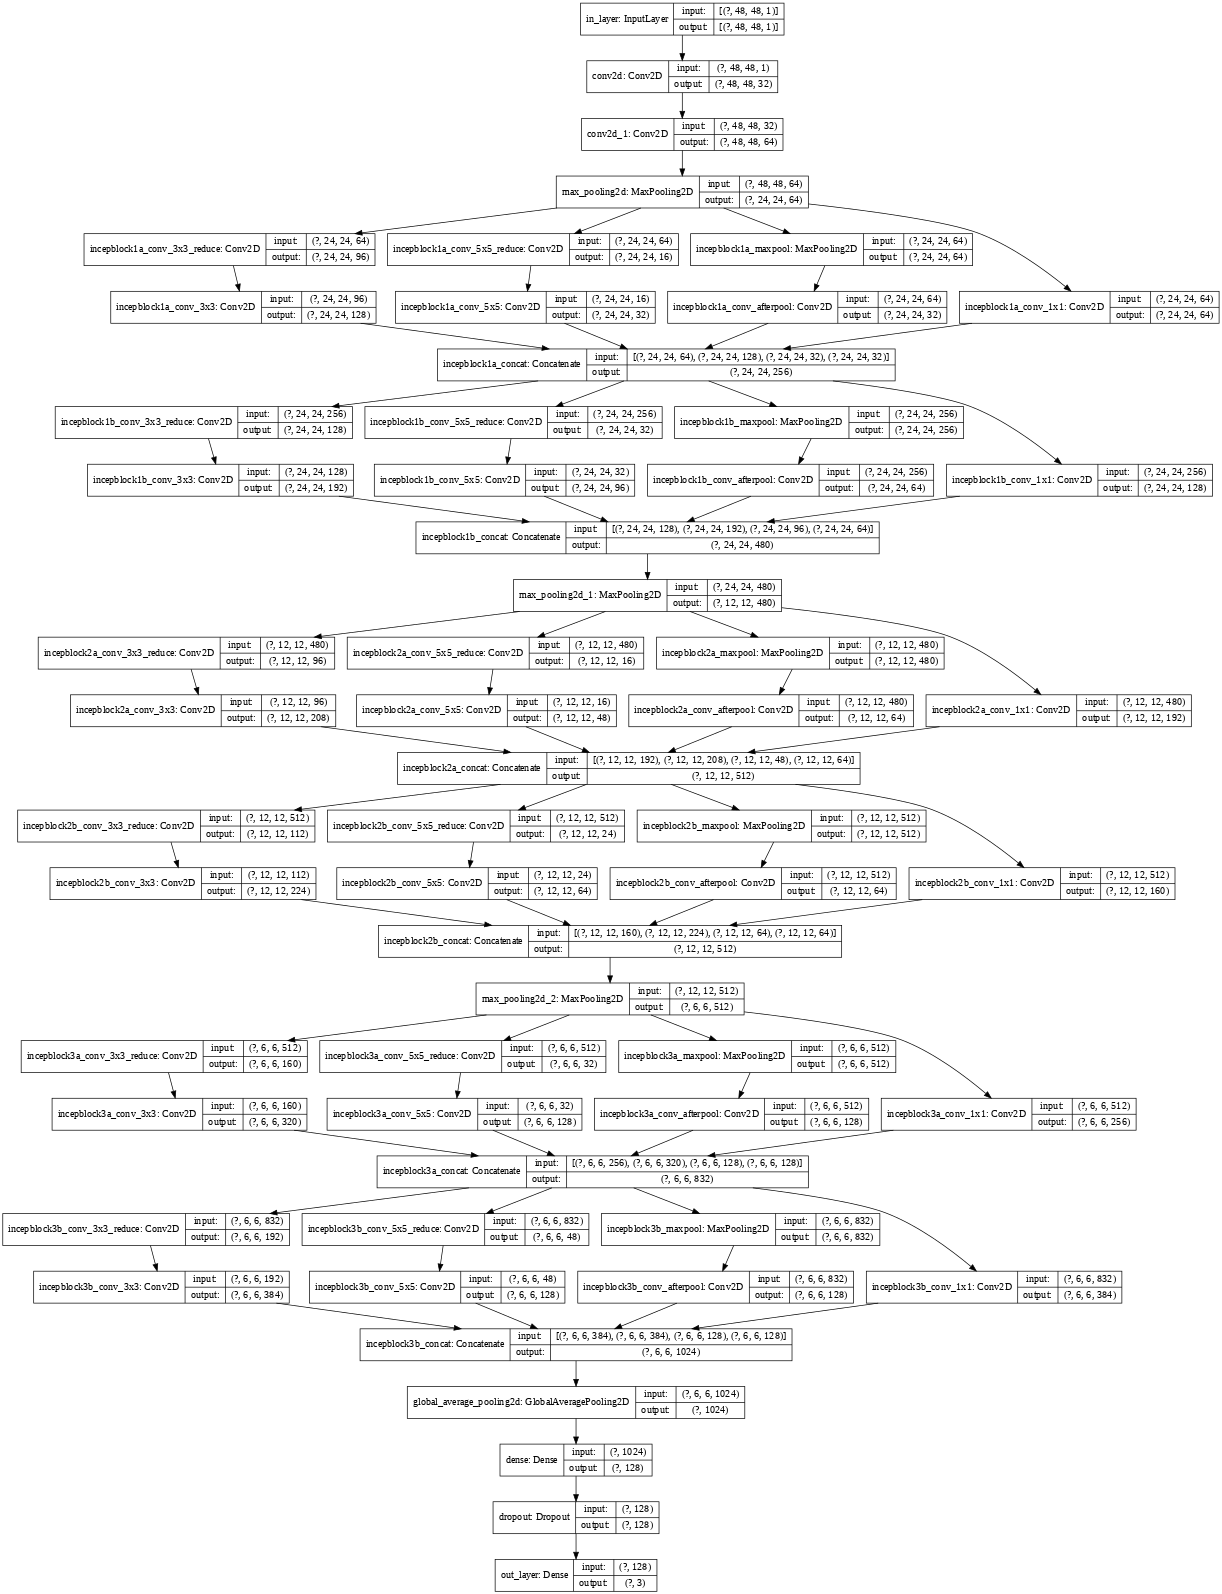

In [0]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50,)

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    min_delta=0.0001,
    factor=0.1,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=13,
    verbose=1,
    restore_best_weights=True,
)

In [0]:
batch_size = 25
loss = "categorical_crossentropy"
optim = optimizers.Adam(0.001)
epochs = 50

In [0]:
model.compile(
        loss=loss,
        optimizer=optim,
        metrics=['accuracy'],
)

train_datagen.fit(X_train)
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data = (X_test, y_test),
    steps_per_epoch = len(X_train) / batch_size,
    epochs = epochs,
    callbacks = [lr_scheduler, early_stopping],
)

Epoch 1/50
158/157 [==============================] - 18s 113ms/step - loss: 1.0952 - accuracy: 0.4740 - val_loss: 1.0330 - val_accuracy: 0.4806 - lr: 0.0010
Epoch 2/50
158/157 [==============================] - 15s 94ms/step - loss: 1.0377 - accuracy: 0.4803 - val_loss: 1.0215 - val_accuracy: 0.4806 - lr: 0.0010
Epoch 3/50
158/157 [==============================] - 15s 95ms/step - loss: 1.0158 - accuracy: 0.4890 - val_loss: 0.9425 - val_accuracy: 0.5070 - lr: 0.0010
Epoch 4/50
158/157 [==============================] - 15s 94ms/step - loss: 0.8589 - accuracy: 0.5711 - val_loss: 0.7115 - val_accuracy: 0.6563 - lr: 0.0010
Epoch 5/50
158/157 [==============================] - 15s 94ms/step - loss: 0.7577 - accuracy: 0.6191 - val_loss: 0.6836 - val_accuracy: 0.6423 - lr: 0.0010
Epoch 6/50
158/157 [==============================] - 15s 95ms/step - loss: 0.7088 - accuracy: 0.6427 - val_loss: 0.6786 - val_accuracy: 0.6656 - lr: 0.0010
Epoch 7/50
158/157 [==============================] - 15s

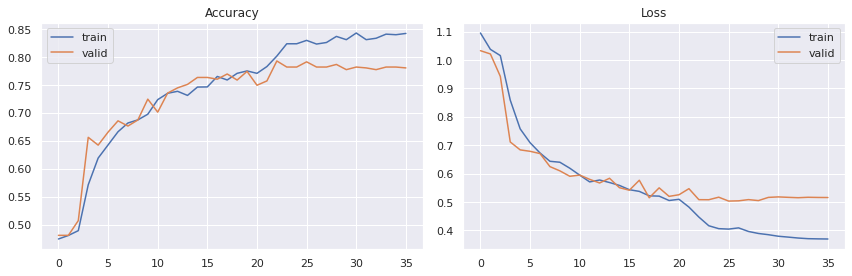

In [0]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.show()

In [0]:
label_to_text

{0: 'Happy', 1: 'Sadness', 2: 'Neutral'}

test accuracy: 79.3157 %


              precision    recall  f1-score   support

           0       0.91      0.93      0.92       309
           1       0.69      0.62      0.65       162
           2       0.68      0.71      0.69       172

    accuracy                           0.79       643
   macro avg       0.76      0.75      0.76       643
weighted avg       0.79      0.79      0.79       643



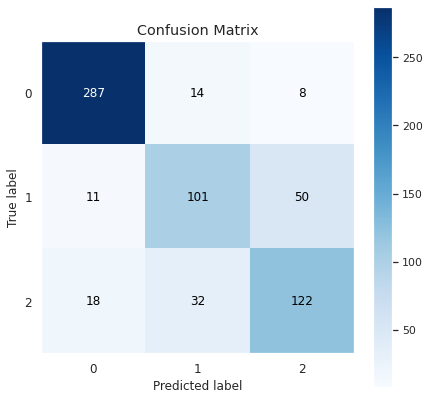

In [0]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")
print(classification_report(ytest_, yhat_test))

In [0]:
yhat_train = np.argmax(model.predict(X_train), axis=1)
ytrain_ = np.argmax(y_train, axis=1)

train_accu = np.sum(ytrain_ == yhat_train) / len(ytrain_) * 100
print(f"train accuracy: {round(train_accu, 4)} %")

train accuracy: 81.5623 %
